Spatial aggregation analysis

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from esda.moran import Moran, Moran_Local
import libpysal
import matplotlib.patches as mpatches

gdf = gpd.read_file("D://kcl/Spatial Data Analysis/assessment2/data/lsoa_IMD_airbnb_housing/lsoa_IMD_airbnb_housing.shp")
# View all field names
print(gdf.columns.tolist())

['LSOA code', 'LSOA name', 'Value', 'LSOA11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ', 'IMDScore', 'IMD2019_5', 'EmpScore', 'EduScore', 'HeaScore', 'CriScore', 'BaHScore', 'EnvScore', 'Mean Price', 'Small Host', 'Multiple L', 'Property C', 'geometry']


In [8]:
# Select and rename the variable
gdf = gdf[['LSOA11NM', 'IMDScore', 'EnvScore', 'Mean Price', 'Small Host', 'Multiple L', 'Property C', 'POPDEN', 'geometry']]
gdf.columns = ['LSOA', 'imd', 'env', 'price', 'airbnb_small', 'airbnb_multi', 'airbnb_density', 'pop_density', 'geometry']
gdf = gdf.dropna()

C:\Users\86180\AppData\Local\Temp\ipykernel_17432\4039442002.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf)


Global Moran's I: 0.7155553235541344
p-value: 0.001


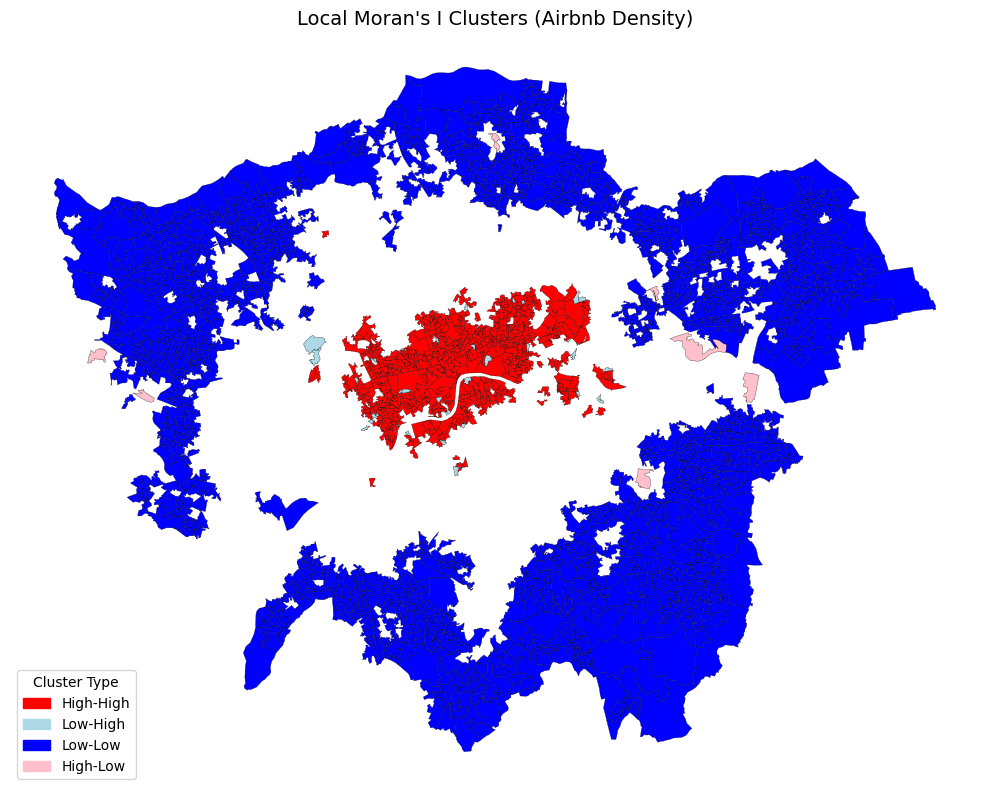

In [9]:
w = libpysal.weights.Queen.from_dataframe(gdf)
w.transform = 'r'
# Calculate global Moran’s I
moran_global = Moran(gdf['airbnb_density'], w)
print("Global Moran's I:", moran_global.I)
print("p-value:", moran_global.p_sim)
# Compute local Moran’s I
moran_local = Moran_Local(gdf['airbnb_density'], w)
# Visualization Local Moran's I
sig = moran_local.p_sim < 0.05
hotspots = sig * moran_local.q
gdf['sig'] = sig
gdf['quad'] = hotspots
gdf['quad_label'] = gdf['quad'].map({
    1: 'High-High',
    2: 'Low-High',
    3: 'Low-Low',
    4: 'High-Low'
})
quad_colors = {
    1: 'red',    
    2: 'lightblue', 
    3: 'blue',   
    4: 'pink'
}
gdf['quad_clean'] = gdf['quad'].where(gdf['quad'].isin([1, 2, 3, 4]), np.nan)
gdf['quad_color'] = gdf['quad_clean'].map(quad_colors)
legend_labels = {
    'High-High': 'red',
    'Low-High': 'lightblue',
    'Low-Low': 'blue',
    'High-Low': 'pink'
}
# Create a hot and cold spot map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.dropna(subset=['quad_color']).plot(color=gdf.dropna(subset=['quad_color'])['quad_color'], ax=ax, edgecolor='black', linewidth=0.2)
ax.set_title("Local Moran's I Clusters (Airbnb Density)", fontsize=14)
patches = [mpatches.Patch(color=c, label=lab) for lab, c in legend_labels.items()]
ax.legend(handles=patches, title='Cluster Type', loc='lower left')
plt.axis('off')
plt.tight_layout()
plt.show()

K-Means Cluster Analysis


Cluster center characteristics:
         airbnb_density        imd       price        env  pop_density
Cluster                                                               
0            117.945455  19.802424  233.869971  46.580606   117.157576
1              9.178433  32.191389   84.533041  27.558728    87.585493
2             29.502149  24.667622  133.420434  38.188467   155.538897
3              7.778338  12.467506  105.304330  22.524484    57.681008


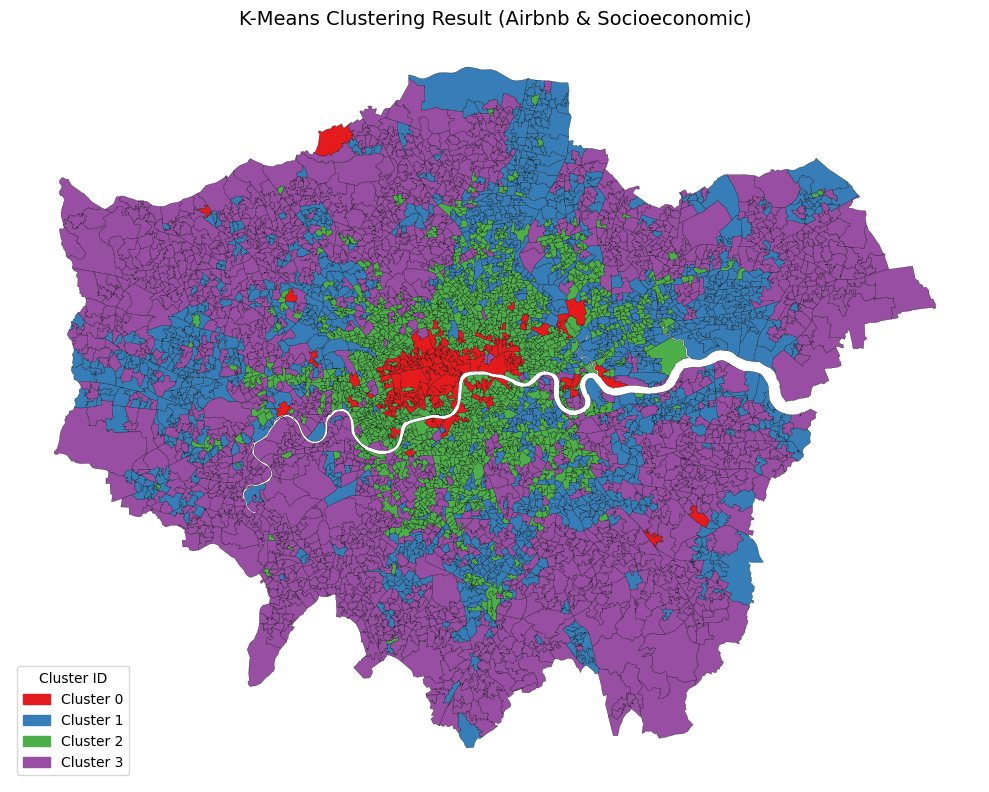

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

cluster_vars = ['airbnb_density', 'imd', 'price', 'env', 'pop_density']
X = gdf[cluster_vars].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
gdf.loc[X.index, 'cluster'] = kmeans.fit_predict(X_scaled)
# Look at the central features of each class
centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=cluster_vars
)
centers.index.name = 'Cluster'
print("\nCluster center characteristics:")
print(centers)
# Visualization
cluster_colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
gdf['cluster_color'] = gdf['cluster'].map(lambda x: cluster_colors[int(x)] if pd.notnull(x) else '#cccccc')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(color=gdf['cluster_color'], ax=ax, edgecolor='black', linewidth=0.2)
ax.set_title("K-Means Clustering Result (Airbnb & Socioeconomic)", fontsize=14)
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=c, label=f'Cluster {i}') for i, c in enumerate(cluster_colors)]
ax.legend(handles=patches, title='Cluster ID', loc='lower left')
plt.axis('off')
plt.tight_layout()
plt.show()